# Package Installation
```python3
# conda update --all 
# conda create -n control-env-3-10 pytest numpy scipy control matplotlib ipykernel slycot pandas python=3.10
```

## Importing Libraries


In [115]:
import numpy as np
import matplotlib.pyplot as plt
import control as ct
import pandas as pd
from numpy.fft import fft
from scipy.signal.windows import hann

## Define Functions

In [116]:
def get_leadlag1(fZero, fPole, Ts):

    alpha = fZero / fPole
    fCenter = fPole * np.sqrt(alpha)
    phaseLift = np.arcsin((1.0 - alpha) / (1.0 + alpha)) * (180.0 / np.pi)

    return get_phase_comp(fCenter, phaseLift, Ts)


def get_leadlag2(fZero, DZero, fPole, DPole, Ts):

    wZero = (2.0 / Ts) * np.tan(np.pi * fZero * Ts)
    wPole = (2.0 / Ts) * np.tan(np.pi * fPole * Ts)

    k0 = wPole * wPole
    k1 = wZero * wZero
    k2 = Ts * Ts * k0 * k1
    k3 = DPole * Ts * wPole * k1
    k4 = DZero * Ts * k0 * wZero
    k5 = 1.0 / (k2 + 4.0 * (k1 + k3))

    b0 = (k2 + 4.0 * (k4 + k0)) * k5
    b1 = 2.0 * (k2 - 4.0 * k0) * k5
    b2 = (k2 + 4.0 * (k0 - k4)) * k5
    a1 = (k2 + 4.0 * (k1 - k3)) * k5
    a0 = b0 + b1 + b2 - 1.0 - a1

    B = [b0, b1, b2]
    A = [1, a0, a1]

    return ct.tf2ss(ct.TransferFunction(B, A, Ts))


def get_lowpass1(fcut, Ts):

    b0 = 1.0 - np.exp(-Ts * 2.0 * np.pi * fcut)
    a0 = b0 - 1.0

    B = [b0, 0]
    A = [1, a0]

    return ct.tf2ss(ct.TransferFunction(B, A, Ts))


def get_lowpass2(fcut, D, Ts):

    wcut = 2.0 * np.pi * fcut
    k1 = 2.0 * D * Ts * wcut

    a1 = 1.0 / (Ts * Ts * wcut * wcut + k1 + 1.0)
    b0 = 1.0 - a1 * (1.0 + k1)
    a0 = b0 - 1.0 - a1

    B = [b0, 0, 0]
    A = [1, a0, a1]

    return ct.tf2ss(ct.TransferFunction(B, A, Ts))


def get_notch(fcut, D, Ts):

    Q = 1.0 / (2.0 * D)
    # prewarp is done implicitly
    omega = 2.0 * np.pi * fcut * Ts
    sn = np.sin(omega)
    cs = np.cos(omega)
    alpha = sn / (2.0 * Q)

    b0 = 1.0 / (1.0 + alpha)
    b1 = -2.0 * cs * b0
    b2 = b0
    a1 = (1.0 - alpha) * b0
    a0 = b1

    B = [b0, b1, b2]
    A = [1, a0, a1]

    return ct.tf2ss(ct.TransferFunction(B, A, Ts))


def get_phase_comp(fCenter, phaseLift, Ts):

    omega = 2.0 * np.pi * fCenter * Ts
    sn = np.sin(phaseLift * (np.pi / 180.0))
    gain = (1.0 + sn) / (1.0 - sn)
    alpha = (12.0 - omega * omega) / (
        6.0 * omega * np.sqrt(gain)
    )  # approximate prewarping (series expansion)
    k = 1.0 / (1.0 + alpha)

    b0 = (1.0 + alpha * gain) * k
    b1 = (1.0 - alpha * gain) * k
    a0 = (1.0 - alpha) * k

    B = [b0, b1]
    A = [1, a0]

    return ct.tf2ss(ct.TransferFunction(B, A, Ts))


def get_integrator(Ts):

    B = [Ts, 0.0]
    A = [1.0, -1.0]

    return ct.tf2ss(ct.TransferFunction(B, A, Ts))


def get_differentiator(Ts):

    B = [1.0 / Ts, -1.0 / Ts]
    A = [1.0, 0]

    return ct.tf2ss(ct.TransferFunction(B, A, Ts))


def get_differentiating_lowpass1(fcut, Ts):

    b0 = 1.0 - np.exp(-Ts * 2.0 * np.pi * fcut)
    a0 = b0 - 1.0
    
    B = [b0/Ts, -b0/Ts]
    A = [1, a0]
    
    return ct.tf2ss(ct.TransferFunction(B, A, Ts))


# @dataclass
class Data:

    def __init__(self, file_name):
        self.__data = pd.read_csv(file_name, header=None)

    def time(self):
        return self.__data.iloc[:, 0]

    def values(self, indices):
        return self.__data.iloc[:, indices]


def estimate_frequency_response(inp, out, window, Noverlap, Nest, Ts, delta=0.0):

    # Check if delta is provided
    if delta is None:
        delta = 0.0

    # Todo: check if it is usefull to remove mean here
    inp = inp - np.mean(inp)
    out = out - np.mean(out)

    Ndata = inp.shape[0]

    # factor 2 so that the magnitude corresponds to a single sided spectrum
    # 2.3*sin(2*pi*f0*time) <=> sqrt(puu(f0)) = 2.3
    W = np.sum(window) / Nest / 2

    Pavg = np.zeros((Nest, 3), dtype=np.complex128)

    Navg = 0
    ind_start = 0
    ind_end = Nest
    Ndelta = Nest - Noverlap
    while ind_end <= Ndata:
        ind = np.arange(ind_start, ind_end)

        inp_act = inp[ind]
        out_act = out[ind]

        # Todo: check if it is usefull to remove mean here
        inp_act = inp_act - np.mean(inp_act)
        out_act = out_act - np.mean(out_act)

        # needed squeeze to make element wise multiplication work correctly
        # inp_act = np.squeeze(inp_act)
        # out_act = np.squeeze(out_act)

        inp_act = window * inp_act
        out_act = window * out_act

        U = fft(inp_act) / (Nest * W)
        Y = fft(out_act) / (Nest * W)

        Pavg += np.vstack([U * np.conj(U), Y * np.conj(U), Y * np.conj(Y)]).T
        Navg += 1

        ind_start += Ndelta
        ind_end += Ndelta

    Pavg /= Navg

    g, c = calc_freqresp_and_cohere(Pavg, delta)
    df = 1 / (Nest * Ts)
    freq = np.arange(0, 1 / Ts, df)

    # Create the FRD (Frequency Response Data) objects
    G = ct.frd(g, freq)
    C = ct.frd(c, freq)

    return G, C, freq, Pavg


def calc_freqresp_and_cohere(P, delta):

    P[:, 0] = P[:, 0] + delta
    g = P[:, 1] / P[:, 0]
    c = np.abs(P[:, 1]) ** 2 / (P[:, 0] * P[:, 2])

    return g, c


def plot_exc(data, indices):

    fig, axs = plt.subplots(3, 1, figsize=(8, 8))
    axs[0].plot(data.time(), data.values(indices["exc"]))
    axs[0].grid(True)
    axs[0].set_ylabel("exc")
    axs[1].plot(data.time(), data.values(indices["sinarg"]))
    axs[1].grid(True)
    axs[1].set_ylabel("sinarg (rad)")
    axs[2].plot(data.time(), data.values(indices["fchirp"]))
    axs[2].grid(True)
    axs[2].set_ylabel("fchirp (Hz)")
    axs[2].set_xlabel("Time (sec)")
    plt.show()


def plot_bode_compare(G, Gc, Gest, Cest, freq, Ts, signal):

    condition = (0 < freq) & (freq < 1 / (2.0 * Ts))
    Gest = Gest.fresp.flatten()
    Gest = Gest[condition]
    Cest = Cest.fresp.flatten()
    Cest = Cest[condition]
    freq = freq[condition]

    mag, phase, _ = G.frequency_response(2.0 * np.pi * freq)

    mag_c, phase_c, _ = Gc.frequency_response(2.0 * np.pi * freq)

    fig, axs = plt.subplots(3, 1, figsize=(8, 8))
    axs[0].semilogx(freq, 20 * np.log10(np.abs(Gest)))
    axs[0].semilogx(freq, 20 * np.log10(mag))
    axs[0].semilogx(freq, 20 * np.log10(mag_c))
    axs[0].set_title(signal)
    axs[0].grid(True)
    axs[0].set_ylabel("Magnitude (dB)")
    axs[1].semilogx(freq, np.angle(Gest, deg=True))
    axs[1].semilogx(freq, phase * (180.0 / np.pi))
    axs[1].semilogx(freq, phase_c * (180.0 / np.pi))
    axs[1].grid(True)
    axs[1].set_ylabel("Phase (deg)")
    axs[2].semilogx(freq, np.abs(Cest))
    axs[2].grid(True)
    axs[2].set_ylabel("Coherence")
    axs[2].set_xlabel("Frequency (Hz)")
    axs[2].set_ylim(-0.05, 1.05)
    plt.show()


def plot_signal(data, indices, signal):

    plt.figure(figsize=(8, 4))
    plt.plot(data.time(), data.values(indices[signal]))
    plt.grid(True)
    plt.ylabel(signal)
    plt.xlabel("Time (sec)")
    plt.title(signal)
    plt.show()

## Load Data

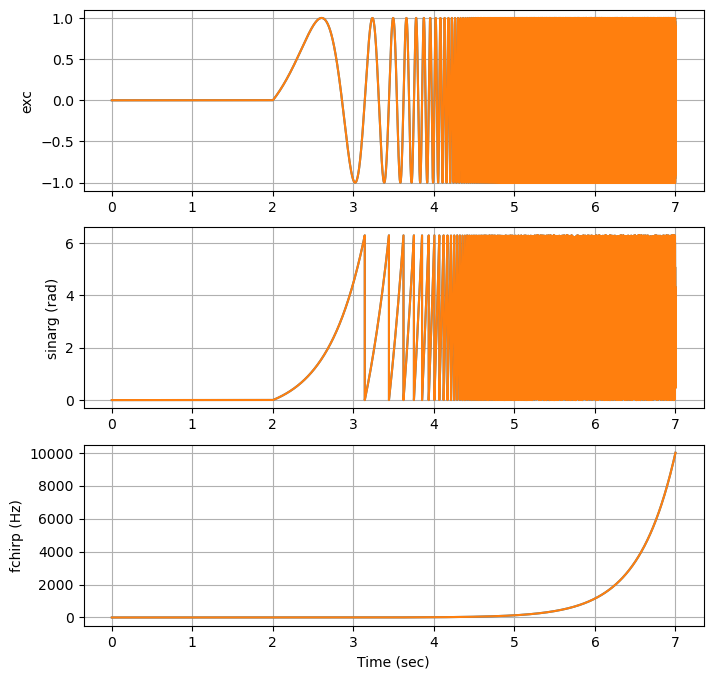

In [117]:
data = Data("../../output/data.txt")

Ts = np.floor(np.mean(np.diff(data.time())) * 1e6) * 1e-6

indices = {
    "exc": [1, 4],
    "fchirp": [2, 5],
    "sinarg": [3, 6],
    "notch": [7, 8],
    "lp2": [9, 10],
    "lp1": [11, 12],
    "ll1": [13, 14],
    "pc1": [15, 16],
    "ll2": [17, 18],
    "inp": [19, 20],
    "fnotch": [21, 22],
    "int": [23, 24],
    "diff": [25, 26],
    "difflp1": [27, 28],
}

# frequency response estimation
Nest = round(1.0 / Ts)
koverlap = 0.9
Noverlap = round(koverlap * Nest)
window = hann(Nest)

plot_exc(data, indices)

## Evaluate Different Filters

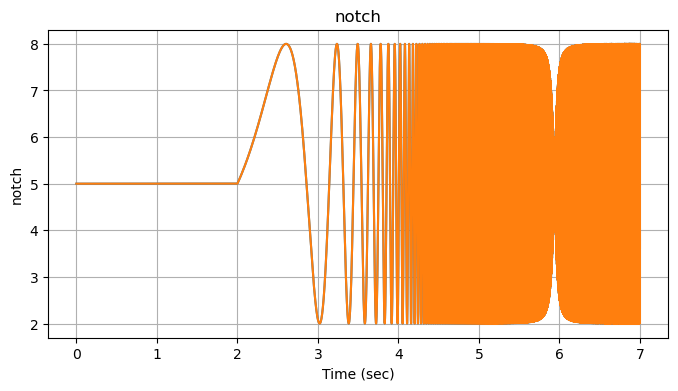

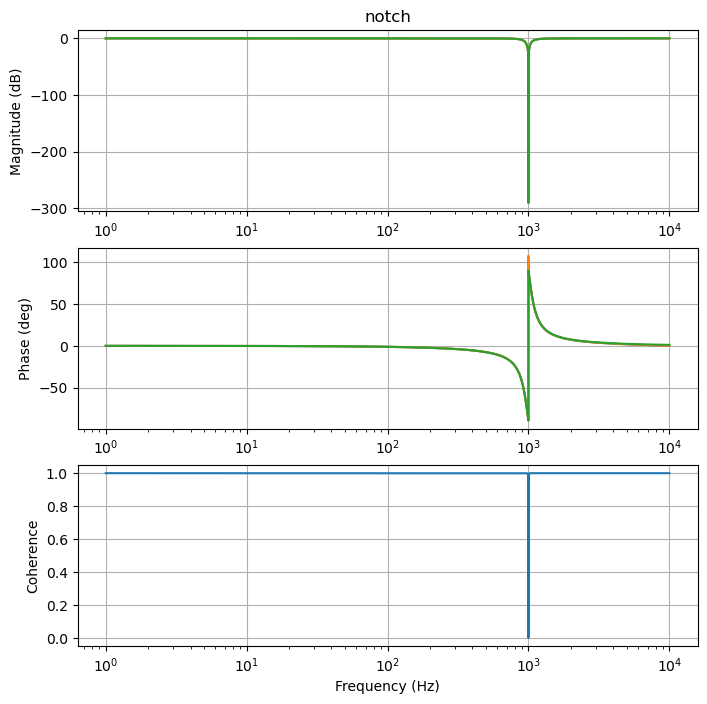

In [118]:
# define NOTCH_F_CUT 1.0e3f
# define NOTCH_D 0.1f

fn = 1.0e3
Dn = 0.1
signal = "notch"

plot_signal(data, indices, signal)

inp = data.values(indices["inp"][0])
out = data.values(indices[signal][0])
Gest, Cest, freq, _ = estimate_frequency_response(inp, out, window, Noverlap, Nest, Ts)

wn = 2.0 * np.pi * fn
Gc = ct.TransferFunction([1.0, 0.0, wn * wn], [1.0, 2.0 * Dn * wn, wn * wn])

plot_bode_compare(get_notch(fn, Dn, Ts), Gc, Gest, Cest, freq, Ts, signal)

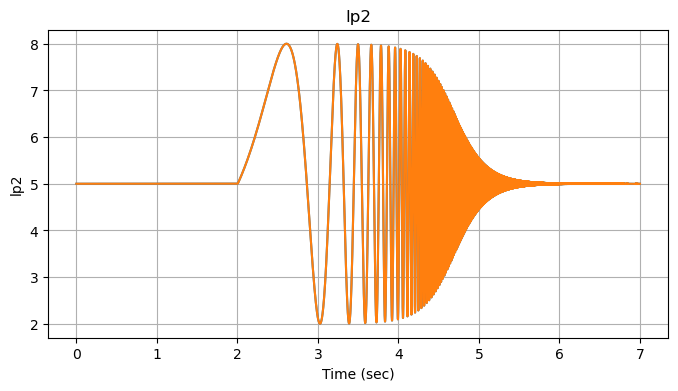

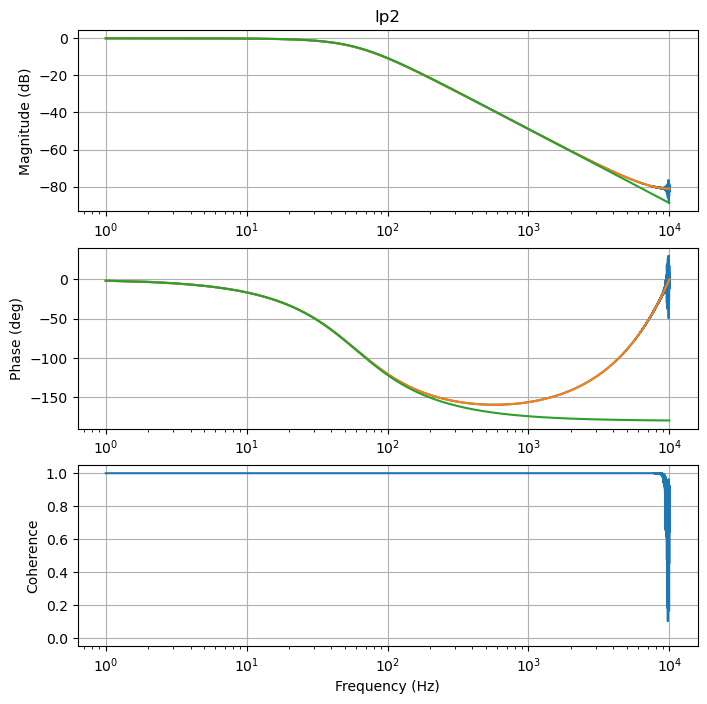

In [119]:
# define LOWPASS2_F_CUT 60.0f
# define LOWPASS2_D (sqrtf(3.0f) / 2.0f)

flp2 = 60.0
Dlp2 = np.sqrt(3.0) / 2.0
signal = "lp2"

plot_signal(data, indices, signal)

inp = data.values(indices["inp"][0])
out = data.values(indices[signal][0])
Gest, Cest, freq, _ = estimate_frequency_response(inp, out, window, Noverlap, Nest, Ts)

wlp2 = 2.0 * np.pi * flp2
Gc = ct.TransferFunction(wlp2 * wlp2, [1.0, 2.0 * Dlp2 * wlp2, wlp2 * wlp2])

plot_bode_compare(get_lowpass2(flp2, Dlp2, Ts), Gc, Gest, Cest, freq, Ts, signal)

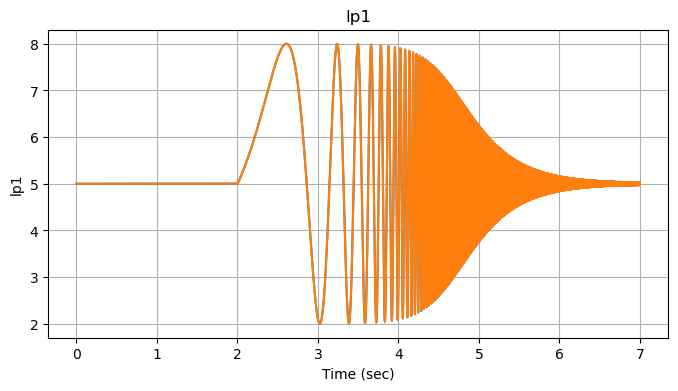

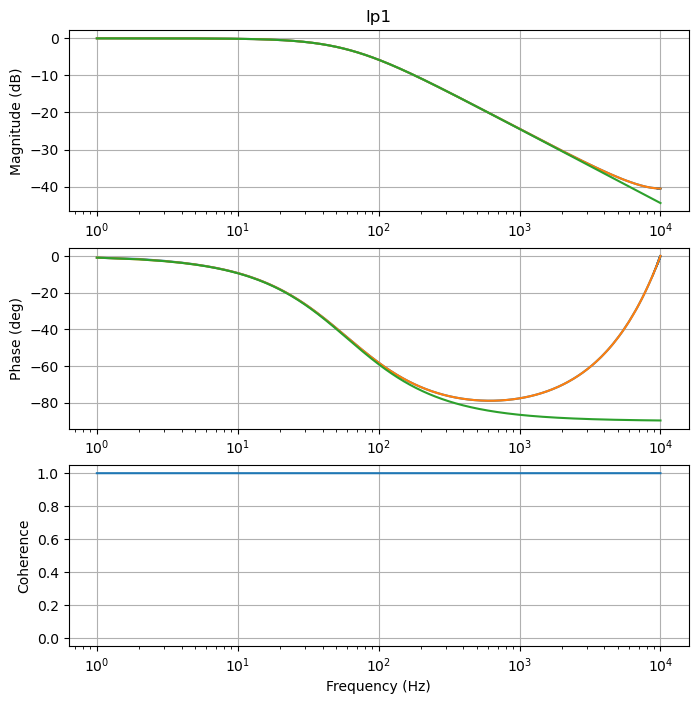

In [120]:
# define LOWPASS1_F_CUT 60.0f

flp1 = 60.0
signal = "lp1"

plot_signal(data, indices, signal)

inp = data.values(indices["inp"][0])
out = data.values(indices[signal][0])
Gest, Cest, freq, _ = estimate_frequency_response(inp, out, window, Noverlap, Nest, Ts)

wlp1 = 2 * np.pi * flp1
Gc = ct.TransferFunction(wlp1, [1.0, wlp1])

plot_bode_compare(get_lowpass1(flp1, Ts), Gc, Gest, Cest, freq, Ts, signal)

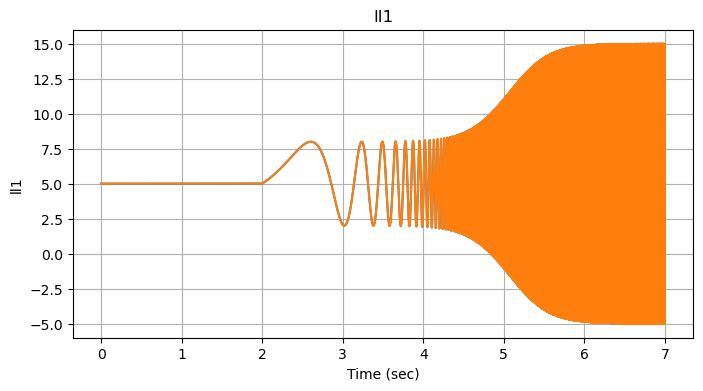

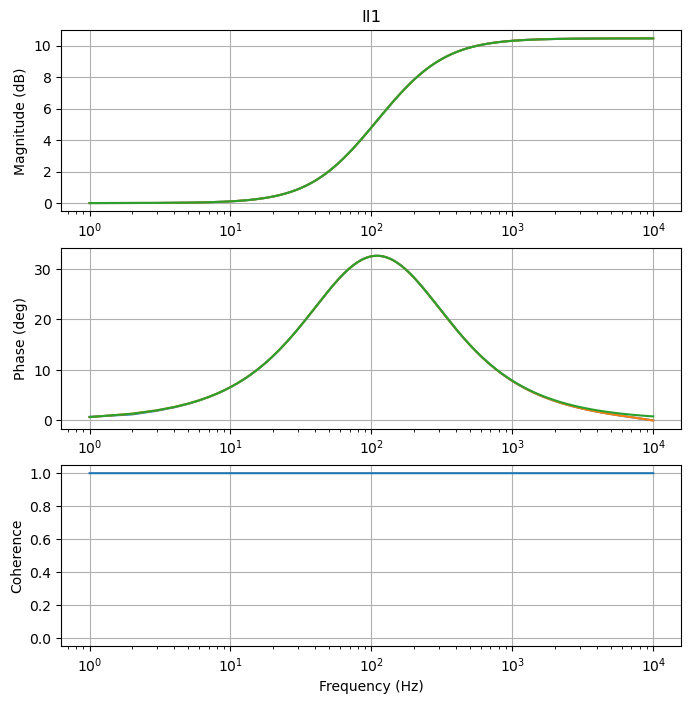

In [121]:
# define LEADLAG1_F_ZERO 60.0f
# define LEADLAG1_F_POLE 200.0f

fz1 = 60.0
fp1 = 200.0
signal = "ll1"

plot_signal(data, indices, signal)

inp = data.values(indices["inp"][0])
out = data.values(indices[signal][0])
Gest, Cest, freq, _ = estimate_frequency_response(inp, out, window, Noverlap, Nest, Ts)

wz1 = 2 * np.pi * fz1
wp1 = 2 * np.pi * fp1
Gc = ct.TransferFunction([wp1 / wz1, wp1], [1.0, wp1])

plot_bode_compare(get_leadlag1(fz1, fp1, Ts), Gc, Gest, Cest, freq, Ts, signal)

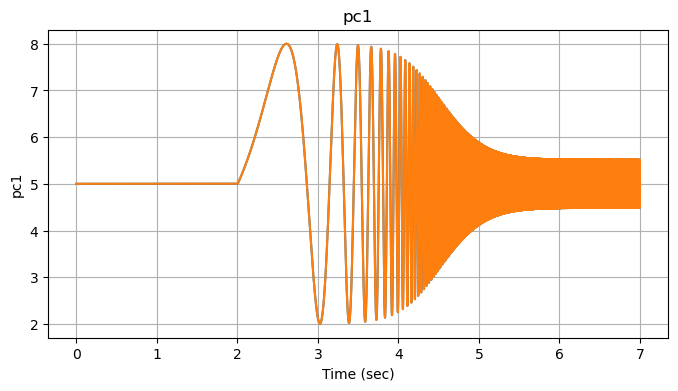

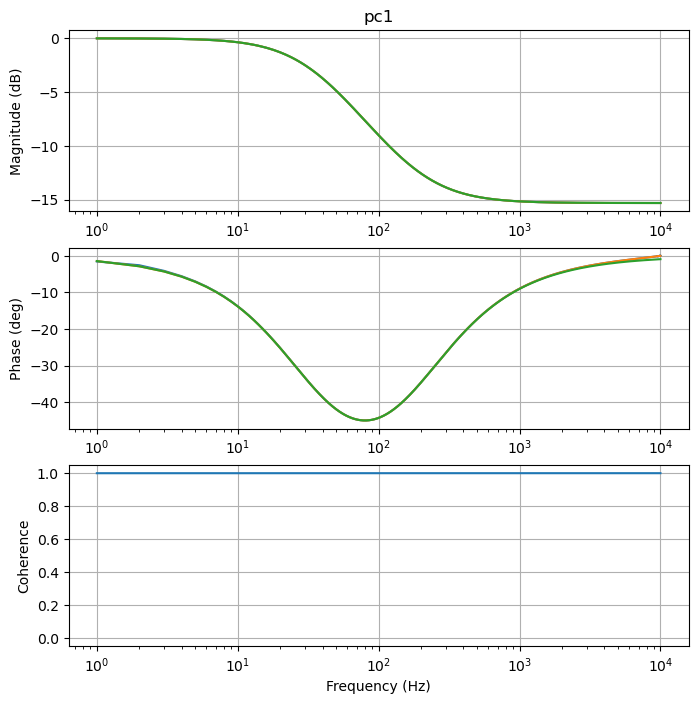

In [122]:
# define PHASECOMP1_F_CENTER 80.0f
# define PHASECOMP1_PHASE_LIFT -45.0f

fc1 = 80.0
phal1 = -45.0
signal = "pc1"

plot_signal(data, indices, signal)

inp = data.values(indices["inp"][0])
out = data.values(indices[signal][0])
Gest, Cest, freq, _ = estimate_frequency_response(inp, out, window, Noverlap, Nest, Ts)

wc1 = 2.0 * np.pi * fc1
sinphi = np.sin(phal1 * np.pi / 180.0)
a = (1.0 - sinphi) / (1.0 + sinphi)
Gc = ct.TransferFunction([1.0 / a, wc1 / np.sqrt(a)], [1.0, wc1 / np.sqrt(a)])

plot_bode_compare(get_phase_comp(fc1, phal1, Ts), Gc, Gest, Cest, freq, Ts, signal)

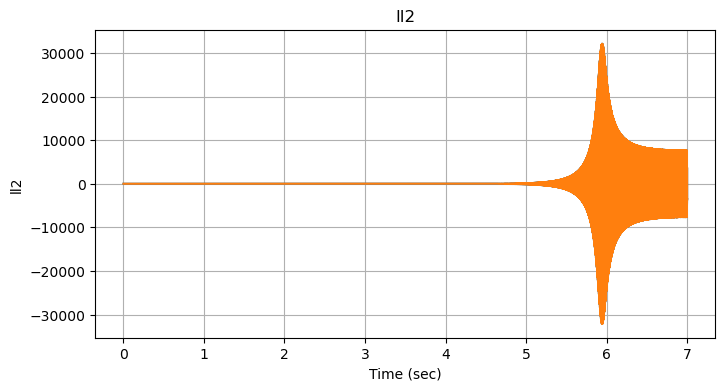

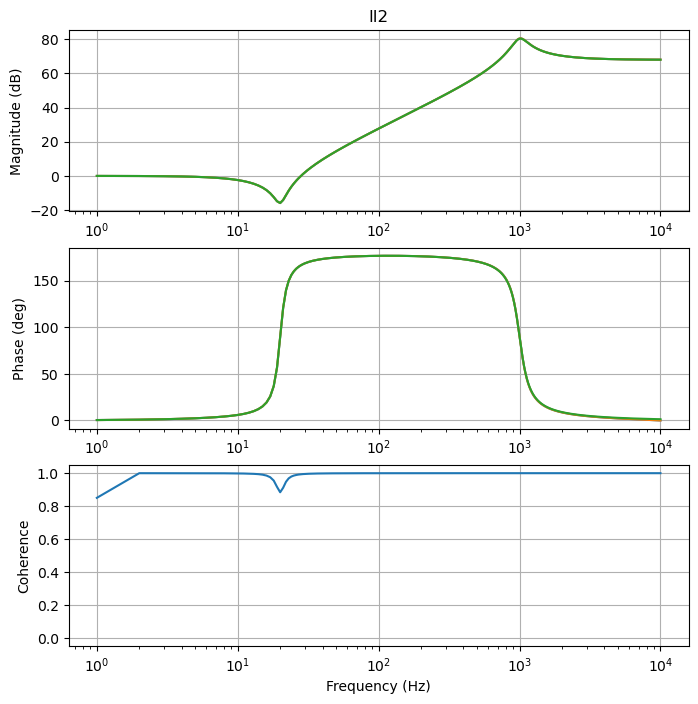

In [123]:
# define LEADLAG2_F_ZERO 20.0f
# define LEADLAG2_D_ZERO 0.08f
# define LEADLAG2_F_POLE 1000.0f
# define LEADLAG2_D_POLE 0.12f

fzll2 = 20.0
Dzll2 = 0.08
fpll2 = 1000.0
Dpll2 = 0.12
signal = "ll2"

plot_signal(data, indices, signal)

inp = data.values(indices["inp"][0])
out = data.values(indices[signal][0])
Gest, Cest, freq, _ = estimate_frequency_response(inp, out, window, Noverlap, Nest, Ts)

wzll2 = 2.0 * np.pi * fzll2
wpll2 = 2.0 * np.pi * fpll2
Gc = ct.TransferFunction(
    [
        (wpll2 * wpll2 / (wzll2 * wzll2)),
        (wpll2 * wpll2 / (wzll2 * wzll2)) * 2 * Dzll2 * wzll2,
        (wpll2 * wpll2 / (wzll2 * wzll2)) * wzll2 * wzll2,
    ],
    [1.0, 2 * Dpll2 * wpll2, wpll2 * wpll2],
)

plot_bode_compare(
    get_leadlag2(fzll2, Dzll2, fpll2, Dpll2, Ts), Gc, Gest, Cest, freq, Ts, signal
)

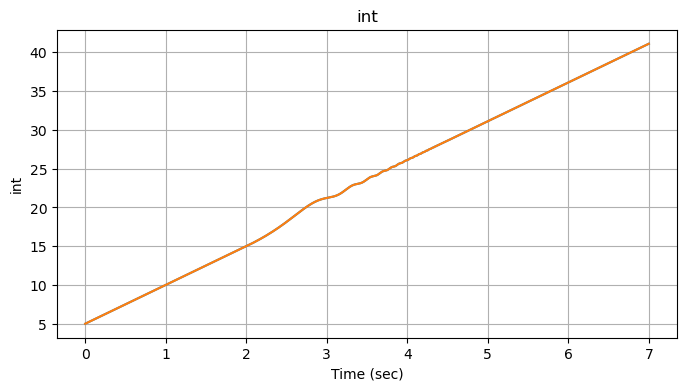

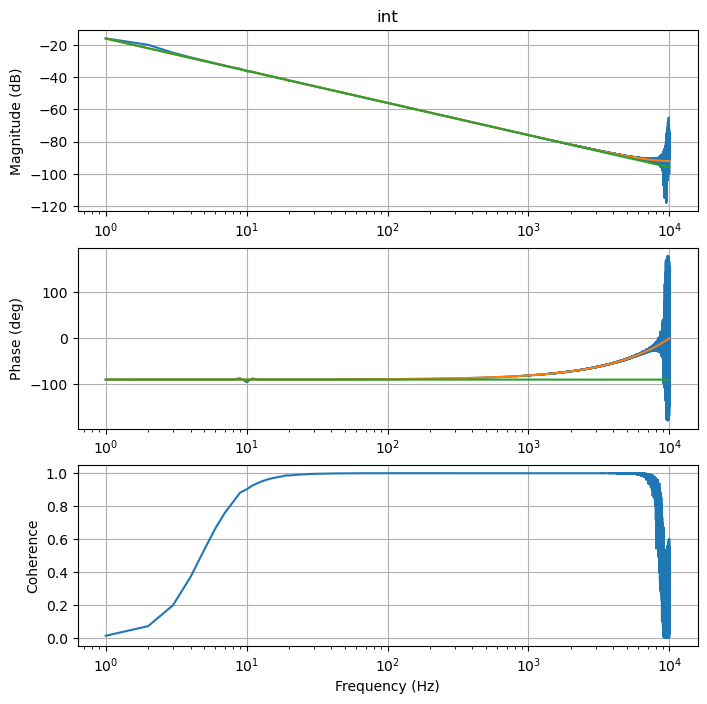

In [124]:
# integrator

signal = "int"

plot_signal(data, indices, signal)

inp = data.values(indices["inp"][0])
out = data.values(indices[signal][0])
Gest, Cest, freq, _ = estimate_frequency_response(inp, out, window, Noverlap, Nest, Ts)

Gc = ct.TransferFunction([0.0, 1.0], [1.0, 0.0])

plot_bode_compare(get_integrator(Ts), Gc, Gest, Cest, freq, Ts, signal)

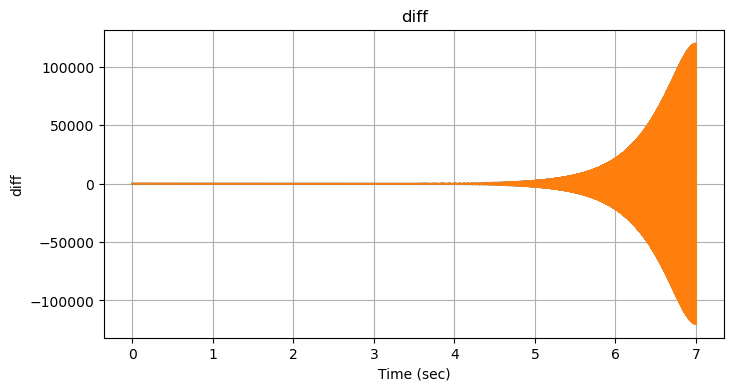

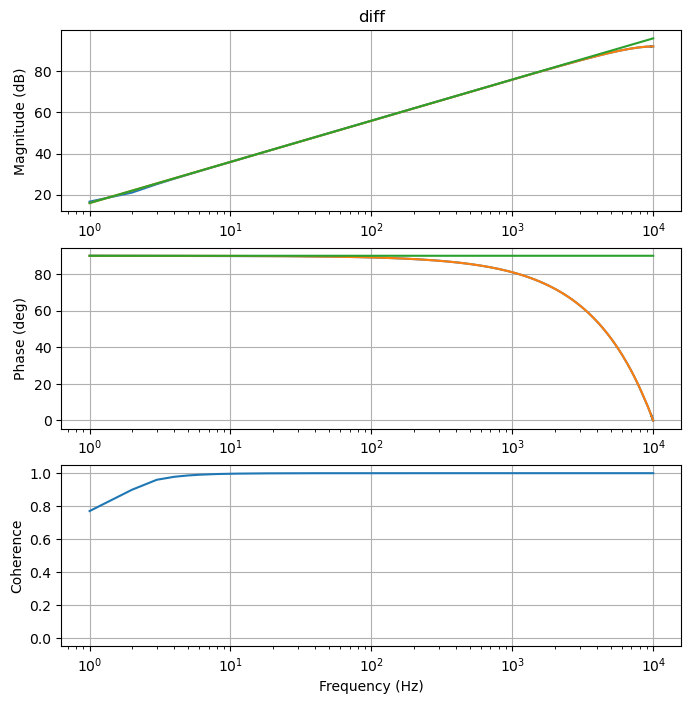

In [125]:
# differentiator

signal = "diff"

plot_signal(data, indices, signal)

inp = data.values(indices["inp"][0])
out = data.values(indices[signal][0])
Gest, Cest, freq, _ = estimate_frequency_response(inp, out, window, Noverlap, Nest, Ts)

Gc = ct.TransferFunction([1.0, 0.0], [0.0, 1.0])

plot_bode_compare(get_differentiator(Ts), Gc, Gest, Cest, freq, Ts, signal)

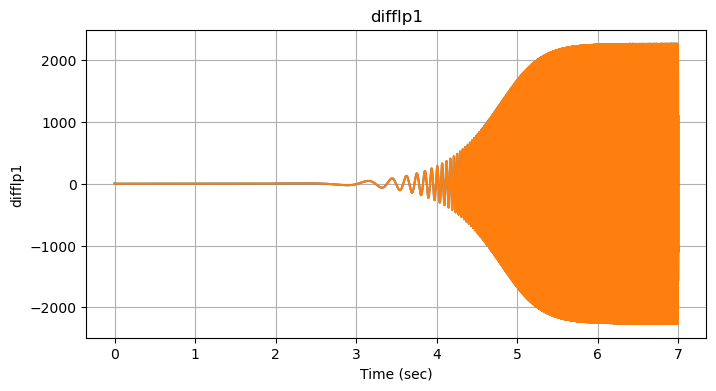

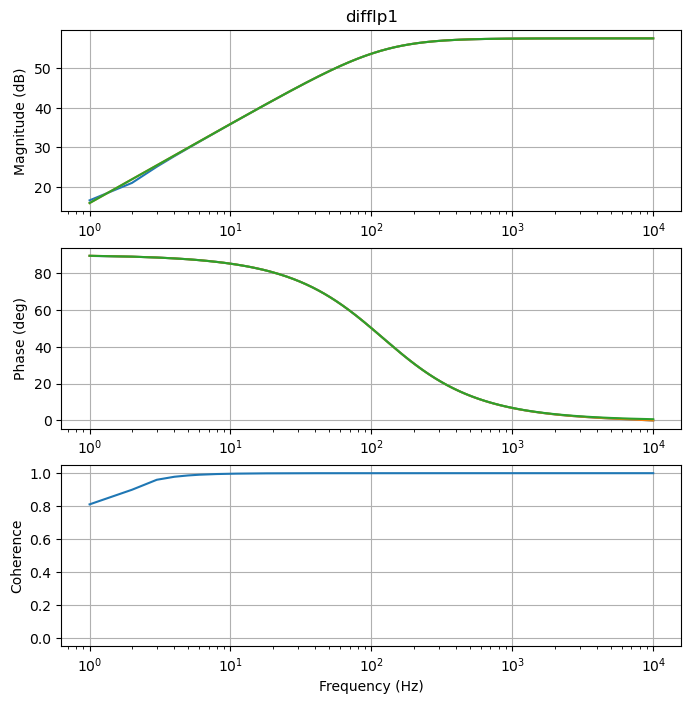

In [126]:
#define DIFF_LOWPASS1_F_CUT 120.0f

fdlp1 = 120.0
signal = "difflp1"

plot_signal(data, indices, signal)

inp = data.values(indices["inp"][0])
out = data.values(indices[signal][0])
Gest, Cest, freq, _ = estimate_frequency_response(inp, out, window, Noverlap, Nest, Ts)

wdlp1 = 2 * np.pi * fdlp1
Gc = ct.TransferFunction([wdlp1, 0.0], [1.0, wdlp1])

plot_bode_compare(get_differentiating_lowpass1(fdlp1, Ts), Gc, Gest, Cest, freq, Ts, signal)

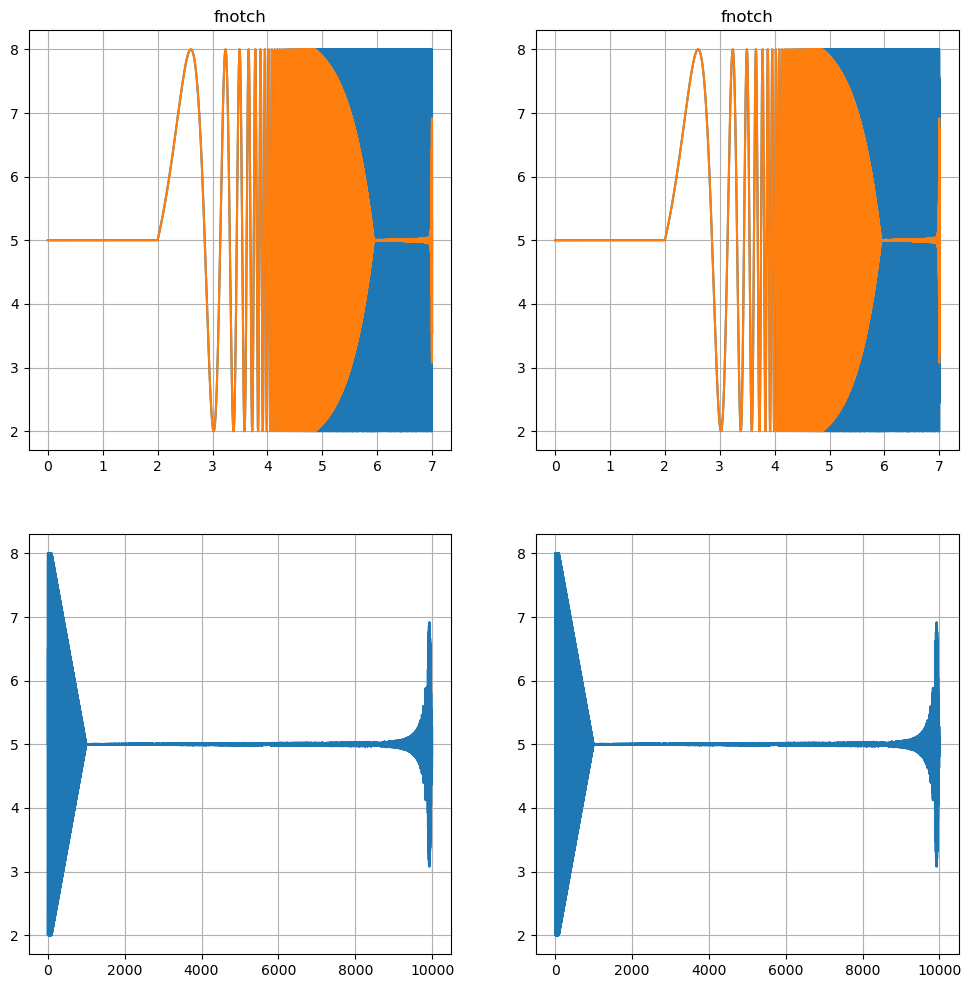

In [127]:
# fading notch

signal = "fnotch"

fig, axs = plt.subplots(2, 2, figsize=(12, 12))
axs[0, 0].plot(data.time(), data.values(indices["inp"][0]))
axs[0, 0].plot(data.time(), data.values(indices[signal][0]))
axs[0, 0].grid(True)
axs[0, 0].set_title(signal)
axs[0, 1].plot(data.time(), data.values(indices["inp"][1]))
axs[0, 1].plot(data.time(), data.values(indices[signal][1]))
axs[0, 1].grid(True)
axs[0, 1].set_title(signal)
axs[1, 0].plot(data.values(indices["fchirp"][0]), data.values(indices[signal][0]))
axs[1, 0].grid(True)
axs[1, 1].plot(data.values(indices["fchirp"][0]), data.values(indices[signal][1]))
axs[1, 1].grid(True)
plt.show()